Recursive Convolution Finite Difference Time Domain
===================================================

Introduction
------------
The Recursive Convolution Finite Difference Time Domain (RC-FDTD) method is used to solve Maxwell's equations by discritizing the electric and magnetic fields in both time and space. The electric field $E$ and the magnetic field $H$ at each time step are used to calculate $E$ and $H$ at the next time step, along with a couple other parameters. The H-field is updated first as follows
$$H^{i+1/2,n+1/2}=H^{i+1/2,n-1/2}-\frac{1}{\mu_0}\frac{\Delta t}{\Delta z}\left[E^{i+1,n}-E^{i,n}\right]$$
The E-field is updated next via
$$E^{i,n+1}=\frac{\epsilon_\infty}{\epsilon_\infty+\chi^0}E^{i,n}+\frac{1}{\epsilon_\infty+\chi^0}\psi^n-\frac{1}{\epsilon_0\left[\epsilon_\infty+\chi^0\right]}\frac{\Delta t}{\Delta z}\left[H^{i+1/2,n+1/2}-H^{i-1/2,n+1/2}\right]-\frac{\Delta tI_f}{\epsilon_0\left[\epsilon_\infty+\chi^0\right]}$$
where $\psi^{i,n}$ is determined by the material present at that index in space
$$\psi^{i,n}=\sum_j\left(\psi^{i,n}_{1,j}+\psi^{i,n}_{2,j}\right)$$
The $j$ index allows for a linear combination of $\psi^{i,n}$ to be utilized to define more complex materials. $\psi^{i,n}_{1,j}$ and $\psi^{i,n}_{2,j}$ are defined as follows
$$\psi^n_{1,j}=E^{i,n}\Delta\chi^{0}_{1,j}+\psi^{n-1}_{1,j}e^{\Delta t\left(-\gamma_j+\beta_j\right)}$$
and
$$\psi^n_{2,j}=E^{i,n}\Delta\chi^{0}_{2,j}+\psi^{n-1}_{2,j}e^{\Delta t\left(-\gamma_j-\beta_j\right)}$$
where $\Delta\chi^0$ represents the difference in susceptability between the first two steps in discritized time. It is computed as follows
$$
\Delta\chi^{0}_{1,j}=\chi^0_{1,j}\left(1-e^{\Delta t\left(-\gamma_j+\beta_j\right)}\right) \\
\Delta\chi^{0}_{2,j}=\chi^0_{2,j}\left(1-e^{\Delta t\left(-\gamma_j-\beta_j\right)}\right)
$$
As one might expect, $\chi^0$ represents the susceptability of the material at the $0$th time step. It is computed as follows
$$
\chi^0_{1,j}=\frac{A_{1,j}}{-\gamma_j+\beta_j}\left[e^{(-\gamma_j+\beta_j)\Delta t}-1\right] \\
\chi^0_{2,j}=\frac{A_{2,j}}{-\gamma_j-\beta_j}\left[e^{(-\gamma_j-\beta_j)\Delta t}-1\right]
$$
The `rcfdtd_sim` package implements these update equations to simulate planewaves interacting with various materials. An example of how `rcfdtd_sim` can be used follows.

Example
-------
We begin by importing the `Sim` (used for simulation) and `Mat` (used to define materials) classes, as well as other needed imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from rcfdtd_sim.sim import Sim, Current, Mat
from rcfdtd_sim import vis

We next want to define our constants. We start with the speed of light `c0`.

In [2]:
c0 = 1 # 300 um/ps

Glancing at the update equations, it is clear that we need to choose $\Delta t$ and $\Delta z$ (which are represented as `dn` and `di` in the code, respectively) such that
$$
\frac{1}{\mu_0}\frac{\Delta t}{\Delta z}=\left(\frac{1}{\epsilon_0}\frac{\Delta t}{\Delta z}\right)^{-1}
$$
as otherwise in the case of vacuum (where $\epsilon_\infty+\chi^0=1$) the update equations will cause both the E-field and H-field to grow in amplitude every two time iterations. As such
$$
\frac{1}{\mu_0}\frac{\Delta t}{\Delta z}=\left(\frac{1}{\epsilon_0}\frac{\Delta t}{\Delta z}\right)^{-1} \to \frac{1}{\mu_0\epsilon_0}\left(\frac{\Delta t}{\Delta z}\right)^2=1 \to c_0^2\left(\frac{\Delta t}{\Delta z}\right)^2=1 \to \Delta t=\frac{\Delta z}{c_0}
$$
So

In [3]:
di = 0.003 # 0.003 um
dn = di/c0 # (0.003 um) / (300 um/ps) = 0.00001 ps = 0.01 fs

Since
$$c=\frac{1}{\sqrt{\epsilon_0\mu_0}}$$
we can set
$$
\epsilon_0=1 \\
\mu_0=1
$$

In [4]:
epsilon0 = 1
mu0 = 1

We next wish to choose the bounds of our simulation in both space and time. Lets say we want our simulation to span from $-3$um to $3$um in space and from $-5$ps to $10$ps in time

In [5]:
i0 = -3
i1 = 3
n0 = -5
n1 = 10

We now utilize the `Sim` class for the first time by making use of its static function `calc_dims`, which yields the dimensions of the simulation in discritized cells

In [6]:
nlen, ilen = Sim.calc_dims(n0, n1, dn, i0, i1, di)
print(f'nlen={nlen}, ilen={ilen}')

nlen=5000, ilen=2002


Now that we know the dimensions of our simulation we can construct our current pulse and material. (You might be thinking that `ilen` is two cells larger than expected-this is done purposefully as the cells on each end are set specially to account for various boundary conditions.) We begin by creating a few objects that will help us create the pulse and material.

In [7]:
# Create a arrays that hold the value of the center of each cell
z = np.linspace(i0+di/2, i1+di/2, ilen, endpoint=False)
t = np.linspace(n0+dn/2, n1+dn/2, nlen, endpoint=False)

Lets position our current pulse at $-2$um and have our material span from $0$um to $3$um

In [8]:
cp_loc_val = -2
m_s_val = 0
m_e_val = 3

We use `t` to determine the indicies that correspond to these locations

In [9]:
cp_loc_ind = np.argmin(np.abs(np.subtract(z, cp_loc_val)))
m_s_ind = np.argmin(np.abs(np.subtract(z, m_s_val)))
m_e_ind = np.argmin(np.abs(np.subtract(z, m_e_val)))
print(f'cp_loc_ind={cp_loc_ind}, m_s_ind={m_s_ind}, m_e_ind={m_e_ind}')

cp_loc_ind=333, m_s_ind=1000, m_e_ind=2001


We are going to use a Gaussian current pulse centered at $0$ps. We are now prepared to create our current pulse and material. We start by making the pulse and plotting it in time.

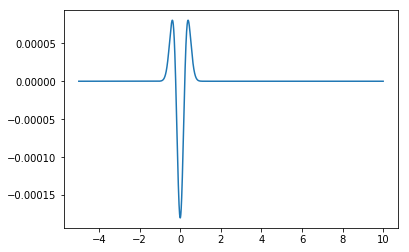

In [10]:
cp_time_val = 0
# Make pulse
cpulse = np.diff(np.diff(np.exp(-((t-cp_time_val)**2)/(0.1))))
# Plot
plt.plot(t[:-2], cpulse)
plt.show()

As expected the pulse is centered at $t=0$. We place the pulse into the `Current` object.

In [11]:
current = Current(nlen, ilen, 0, cp_loc_ind, cpulse)

We choose constants for our material. We will be using a uniform material with a single oscillator. By single oscillator we mean
$$
\sum_j\left(\psi^{i,n}_{1,j}+\psi^{i,n}_{2,j}\right)=\psi^{i,n}_{1,1}+\psi^{i,n}_{2,1}
$$
We choose $\gamma$ and $\omega$ as well as $A_1$ and $A_2$. $\beta$ is calculated via
$$
\beta=\sqrt{\gamma^2-\omega^2}
$$

In [12]:
# Set constants
gamma = np.complex64(0.01 * 2 * np.pi)
omega = np.complex64(0.0)
a1 = np.complex64(160/(2*gamma))
a2 = np.complex64(-160/(2*gamma))
# Calculate beta
beta = np.sqrt(np.add(np.square(gamma), -np.square(omega)))

We need to represent each constant in our material in a matrix with the following structure
![title](../docs/images/material_numpy_structure.png)
Since we are only using a single oscillator, the number of $j$ indicies is 1. The number of $i$ indicies can be calculated from the difference between the material end and start indicies. We need to create a separate matrix for $\gamma$, $\beta$, $A_1$, and $A_2$. Since our material is constant (i.e. its properties don't change over time and space), every matrix will be populated with identical elements. We create these matricies next

In [13]:
# Determine matrix length
mlen = m_e_ind - m_s_ind
# Create matrices
m = np.ones((1, mlen), dtype=np.complex64)
mgamma = m * gamma
mbeta = m * beta
ma1 = m * a1
ma2 = m * a2

We finally define the high frequency permittivity of our material and create our material object

In [14]:
inf_perm = 16
material = Mat(dn, ilen, m_s_ind, inf_perm, ma1, ma2, mgamma, mbeta)

We are now ready to run our simulation! We create our simulation object, storing $1/5$ of the field values (by setting `nstore=int(nlen/5)`) as well as all the field values at `i=1` and `i=ilen-2` (by setting `storelocs=[1,ilen-2]`). We then call the simulation object's `simulate` function to run the simulation

In [15]:
# Create Sim object
s = Sim(i0, i1, di, n0, n1, dn, epsilon0, mu0, 'absorbing', current, material, nstore=int(nlen/5), storelocs=[1,ilen-2])
# Run simulation
s.simulate()

Executing simulation: 100%|██████████| 5000/5000 [00:02<00:00, 1869.57it/s]


We can now examine the results of our simulation using the functions stored in `vis`. We start by viewing the E-field and H-field passing points $i=1$ and $i=2000$ as a function of time using the `plot_loc` function

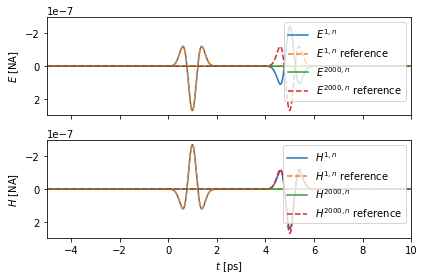

In [16]:
vis.plot_loc(s, nunit='ps')

We also save a video of the simulation in time by using the `timeseries` function

In [17]:
# Don't view inline
%matplotlib qt

In [18]:
vis.timeseries(s, iunit='microns')